In [7]:
%matplotlib inline
from skimage.feature import corner_harris
import cv2
import skimage
from skimage import data, io, draw, color, transform, filters, feature
from skimage.io import imshow
from skimage.filters import rank
import scipy
import matplotlib as plt
import numpy as np
import matplotlib.pyplot as plttc
from skimage.feature import blob_log
from skimage.color import rgb2gray

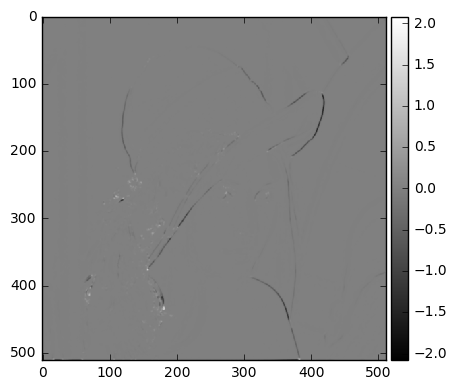

In [10]:

lenna_o = data.imread('lenna.jpg')
lenna = skimage.img_as_float(lenna_o)

imshow(corner_harris(lenna),cmap='gray')


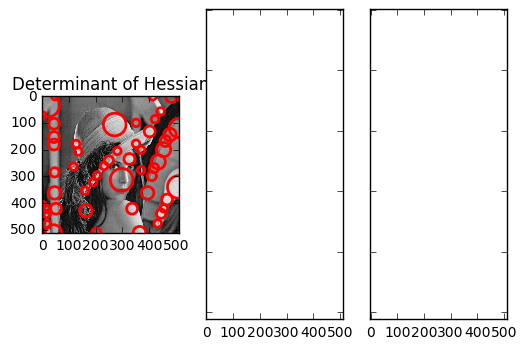

In [34]:
lenna = rgb2gray(lenna)
log = blob_log(lenna,threshold=0.1,min_sigma=10,max_sigma=30)
log[:, 2] = log[:, 2] * sqrt(2)



fig,axes = plt.subplots(1, 3, sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})
axes = axes.ravel()
ax = axes[0]
axes = axes[1:]
ax.set_title(title)
ax.imshow(lenna, interpolation='nearest',cmap='gray')
for blob in log:
    y,x,r = blob
    c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
    ax.add_patch(c)

plt.show()
    


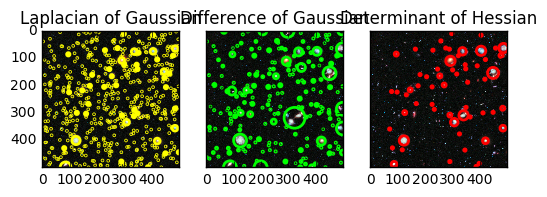

In [11]:
from matplotlib import pyplot as plt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
from skimage.color import rgb2gray

image = data.hubble_deep_field()[0:500, 0:500]
image_gray = rgb2gray(image)

blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)
# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)


fig,axes = plt.subplots(1, 3, sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})
axes = axes.ravel()
for blobs, color, title in sequence:
    ax = axes[0]
    axes = axes[1:]
    ax.set_title(title)
    ax.imshow(image, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax.add_patch(c)

plt.show()